<a href="https://colab.research.google.com/github/Robbysaidiii/Dicoding_Proyek_klasifikasasi/blob/main/Submission_Proyek_Klasifikasi_Gambar_BMLP_Roby_Saidi_Prasetyo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**importlibrary**

In [18]:
# ===== CORE LIBRARIES =====
import os
import random
import shutil
from math import floor
from collections import Counter

# ===== IMAGE PROCESSING =====
from PIL import Image

# ===== DEEP LEARNING =====
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model

# ===== VISUALIZATION =====
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ===== MODEL EVALUATION =====
from sklearn.metrics import classification_report, confusion_matrix

#**Dataset**

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("npurav/animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals


#**Exploratory Data Analysis**

In [20]:
print("Dataset path:", path)
print("Isi folder dataset:")
print(os.listdir(path))

Dataset path: /kaggle/input/animals
Isi folder dataset:
['animals']


menunjukkan isi folder dataset, yang merupakan langkah awal untuk memahami struktur direktori.

In [21]:
dataset_dir = '/kaggle/input/animals/animals/dataset'

class_counts = {}
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

total_data = sum(class_counts.values())  # Menjumlahkan seluruh data

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Jumlah Data: {count}")

print(f"\nJumlah Kelas: {len(class_counts)}")
print(f"\nTotal Seluruh Data: {total_data}")


Class: bradypus-variegatus, Jumlah Data: 50
Class: mergus-serrator, Jumlah Data: 50
Class: mimus-polyglottos, Jumlah Data: 50
Class: ursus-arctos-horribilis, Jumlah Data: 91
Class: carcharodon-carcharias, Jumlah Data: 92
Class: aquila-chrysaetos, Jumlah Data: 113
Class: pterois-volitans, Jumlah Data: 50
Class: canis-lupus-familiaris, Jumlah Data: 1635
Class: gorilla-gorilla, Jumlah Data: 445
Class: vultur-gryphus, Jumlah Data: 50
Class: gallus-gallus-domesticus, Jumlah Data: 776
Class: spheniscus-demersus, Jumlah Data: 50
Class: orcinus-orca, Jumlah Data: 33
Class: balaenoptera-musculus, Jumlah Data: 181
Class: anas-platyrhynchos, Jumlah Data: 50
Class: panthera-onca, Jumlah Data: 49
Class: macropus-giganteus, Jumlah Data: 405
Class: canis-lupus, Jumlah Data: 276
Class: giraffa-camelopardalis, Jumlah Data: 523
Class: apis-mellifera, Jumlah Data: 50
Class: aptenodytes-forsteri, Jumlah Data: 274
Class: tursiops-truncatus, Jumlah Data: 89
Class: passerina-ciris, Jumlah Data: 50
Class: cat


Menghitung jumlah gambar/file untuk setiap kelas (spesies hewan)
Menampilkan jumlah data per kelas
Menghitung total kelas (117) dan total data (19.225)

##RESOLUSI GAMBAR

In [22]:
#Simpan semua resolusi
resolutions = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                resolutions.append(img.size)  # (width, height)
            except:
                continue

# Hitung dan tampilkan ukuran yang paling umum
res_counter = Counter(resolutions)
print("Top 10 resolusi gambar yang ditemukan:")
print(res_counter.most_common(10))

# Total variasi resolusi
print(f"\nTotal variasi resolusi unik: {len(set(resolutions))}")


Top 10 resolusi gambar yang ditemukan:
[((224, 224), 4872), ((300, 300), 1283), ((1000, 667), 1272), ((256, 256), 894), ((500, 375), 702), ((1000, 1500), 528), ((275, 183), 440), ((300, 168), 265), ((500, 374), 258), ((499, 375), 218)]

Total variasi resolusi unik: 3214


dilihat dari hasil resolusi, data mempunyai ukuran gambar yang berbeda dan yang paling banyak adalah resolusi gambar 224 sebanyak 4872 menunjukkan bahwa sebagian gambar sudah di-resize ke dimensi standar.
Resolusi seperti (1000, 1500) (portrait) dan (300, 168) landscape ekstrem.

Ada 3.214 resolusi unik berbeda!
Masalah: Variasi yang ekstrem bisa memengaruhi pelatihan model

#Pra-pemrosesan Data Gambar

In [23]:
# Path ke dataset asli dan folder output
base_output_dir = '/content/split_dataset'

# Proporsi split (misalnya: 90% train, 5% val, 5% test)
train_ratio = 0.90
val_ratio = 0.05
test_ratio = 0.05

# Buat folder split
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_output_dir, split), exist_ok=True)

# Loop per kelas
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = floor(total * train_ratio)
    val_count = floor(total * val_ratio)
    test_count = total - train_count - val_count  # sisanya ke test

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Simpan file ke folder masing-masing
    for split_name, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(base_output_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img in split_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copy2(src, dst)

print("Data berhasil dibagi dengan rasio 90:5:5 (train:val:test)")


Data berhasil dibagi dengan rasio 90:5:5 (train:val:test)



Dataset asli dipecah menjadi 3 subset:

---


Train (90%): Untuk melatih model.
Validation (5%): Untuk mengevaluasi model selama pelatihan (misalnya tuning hyperparameter).
Test (5%): Untuk evaluasi final model.

##Pipeline

In [24]:

# Step 5: Load dataset
batch_size = 32
img_size = (224, 224)
base_dir = base_output_dir

train_dir = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

valid_dir = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_dir = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 19213 files belonging to 117 classes.
Found 4078 files belonging to 117 classes.
Found 4713 files belonging to 117 classes.


data sudah terbagi menjadi 3


*   train sebanyak 19212
*   val sebanyak 3352
*.  test seabnyak 3866


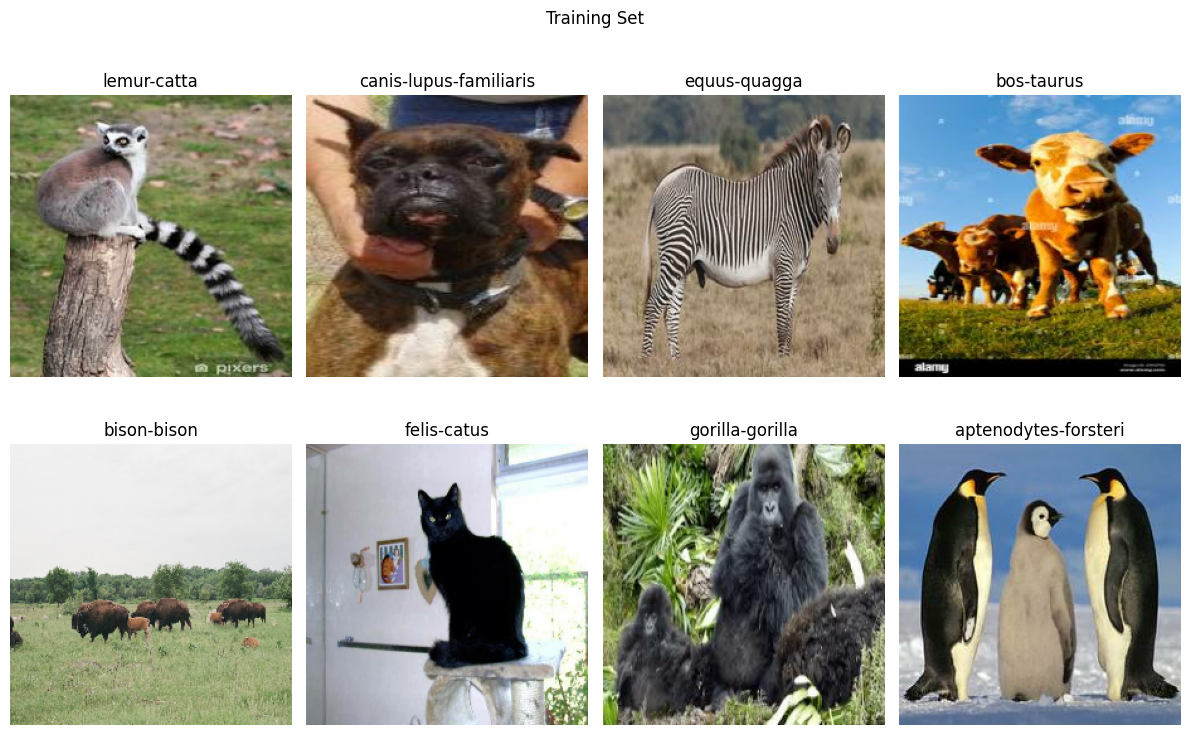

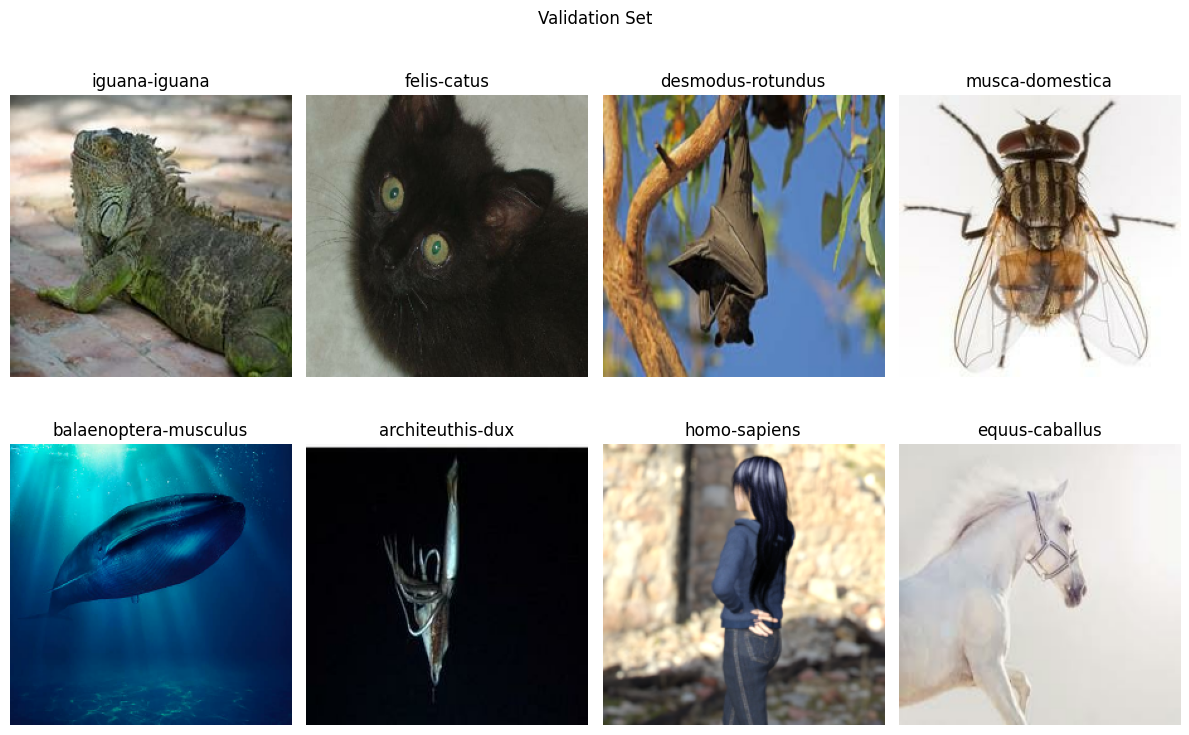

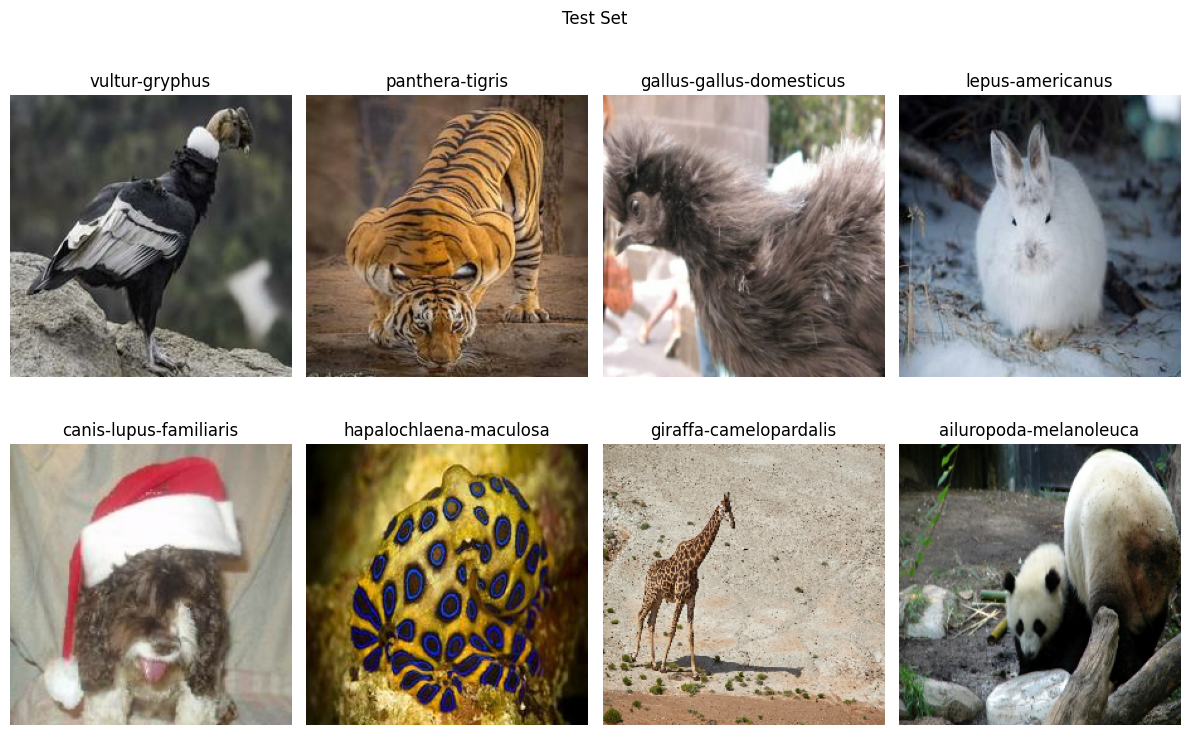

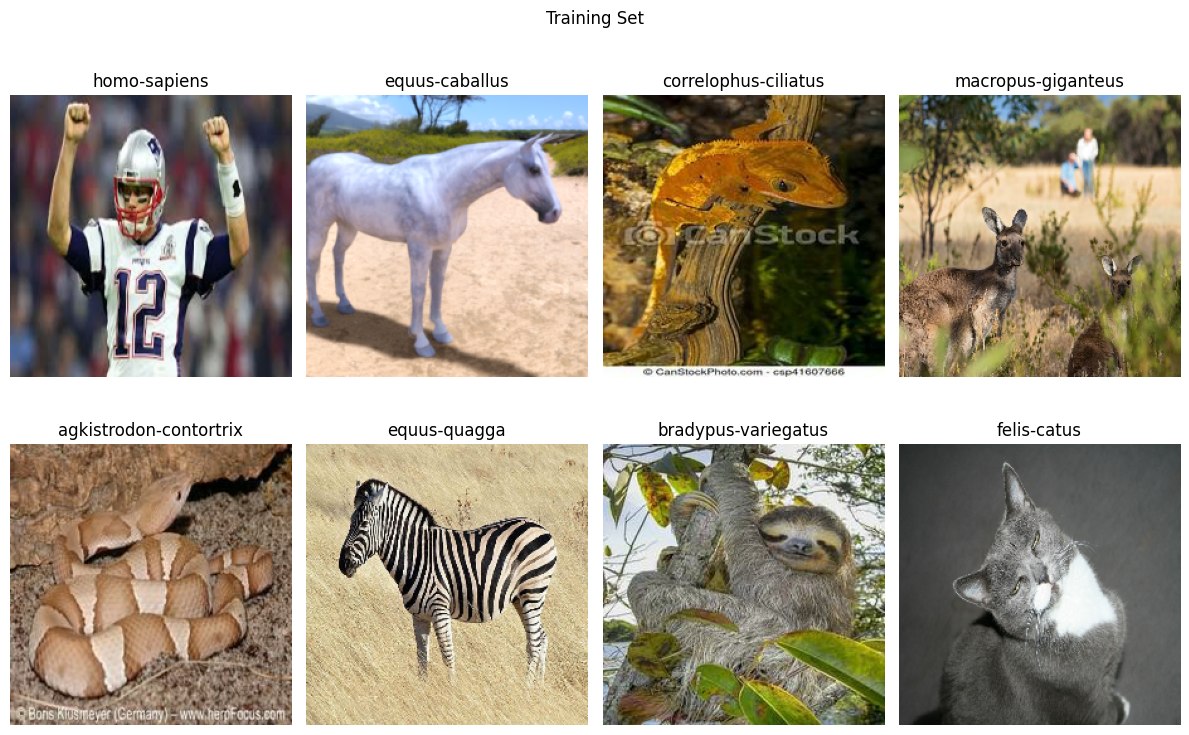

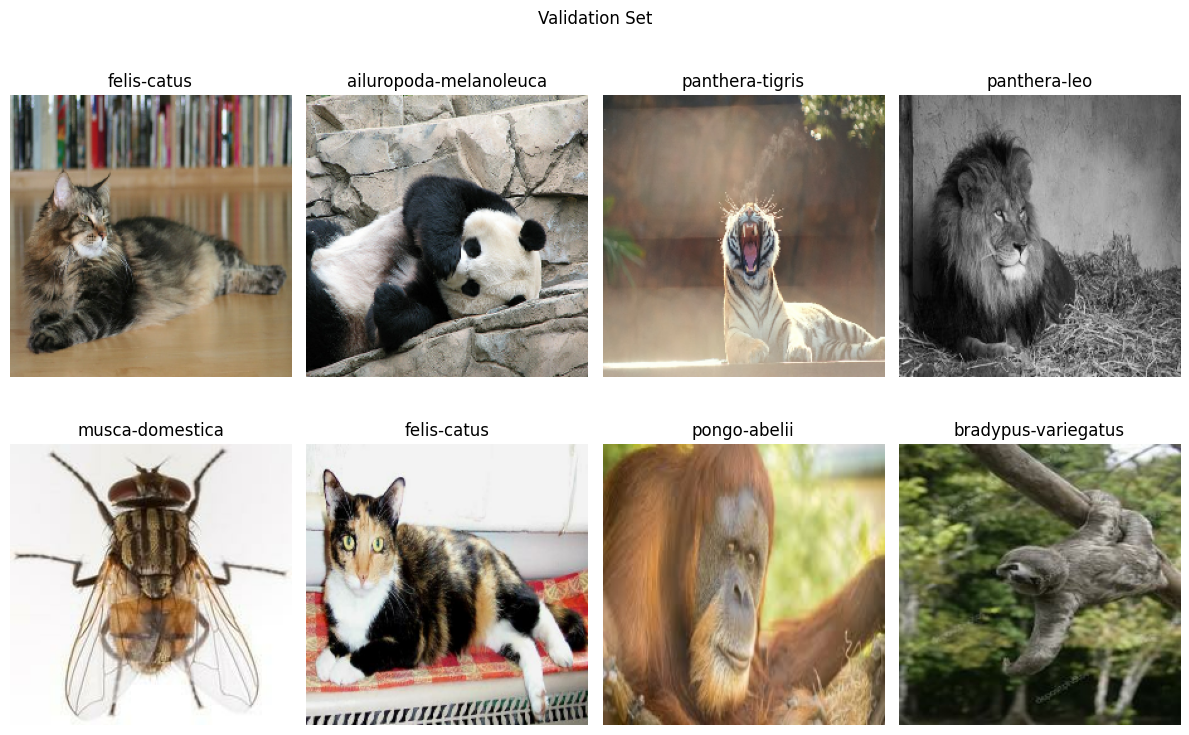

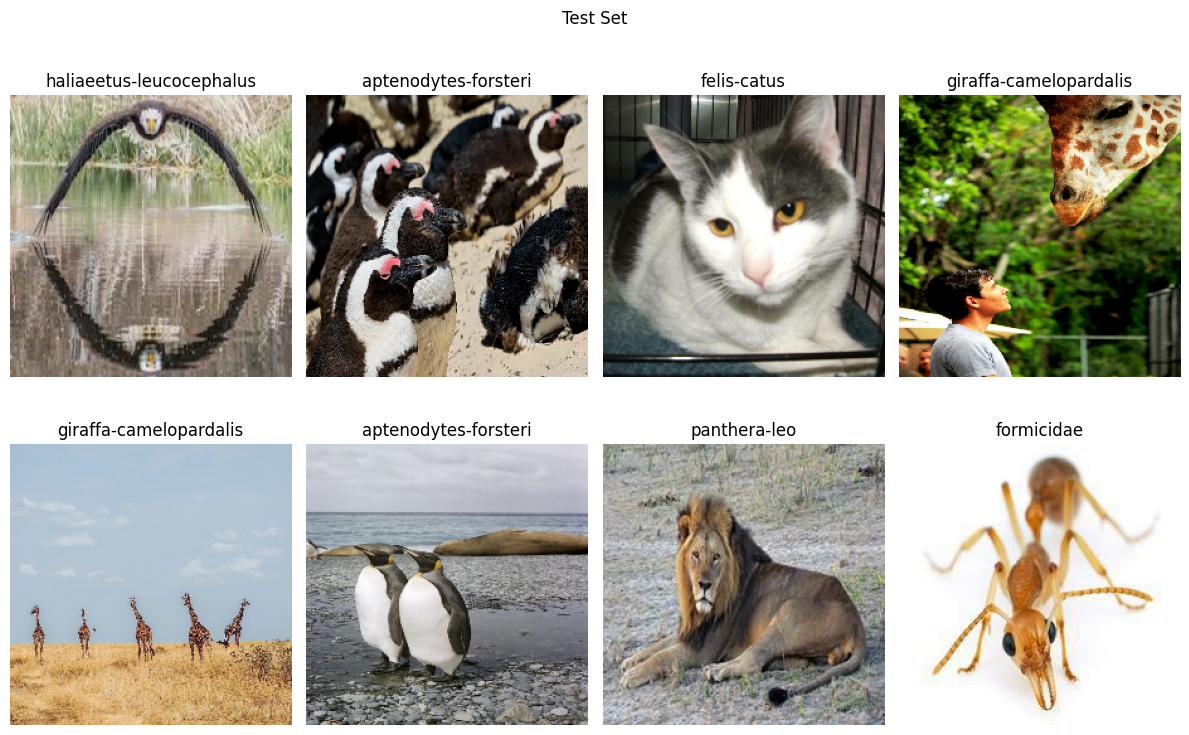

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Visualisasi sample foto pada masing masing split
class_names = train_dir.class_names

def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(train_dir, title="Training Set")
show_images(valid_dir, title="Validation Set")
show_images(test_dir, title="Test Set")
# Visualisasi sample foto pada masing masing split
class_names = train_dir.class_names

def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(train_dir, title="Training Set")
show_images(valid_dir, title="Validation Set")
show_images(test_dir, title="Test Set")

ini adalh hasil nya bahawa data sudah berhasil terbagi dari 117 clas

##Augmentation

In [26]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("both"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomShear(0.3),
])



Meningkatkan generalisasi model
Mengatasi limited training data
Membantu model belajar fitur yang lebih robust


#**model CNN**

In [27]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Augmentasi (opsional, kalau pakai)
    layers.Rescaling(1./255),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Dropout dan Dense
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(117, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 117)            │        15,093 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,053 (42.66 MB)

 Trainable params: 11,184,053 (42.66 MB)

 Non-trainable params: 0 (0.00 B)


Model ini cukup dalam dengan 3 lapis konvolusi dan cukup besar jumlah neuronnya di bagian dense.
Terakhir, ada 117 kelas, yang menunjukkan bahwa ini digunakan untuk klasifikasi 117 jenis makanan.
Layer dropout membantu menghindari overfitting, terutama karena dense layer sangat besar (86528 → 64).


#**Callback dan training**

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96 and logs.get('accuracy')>0.96):
      print("\nAkurasi telah mencapai > 96%!")
      self.model.stop_training = True
callbacks = myCallback()

 berfungsi untuk menghentikan proses pelatihan model secara otomatis jika akurasi pada data pelatihan (accuracy) dan data validasi (val_accuracy) telah melebihi 96%.

In [29]:
history = model.fit(
    train_dir,
    validation_data=valid_dir,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 91s 145ms/step - accuracy: 0.1570 - loss: 3.7766 - val_accuracy: 0.3718 - val_loss: 2.5967
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 129s 127ms/step - accuracy: 0.3509 - loss: 2.7020 - val_accuracy: 0.5017 - val_loss: 1.9772
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 76s 126ms/step - accuracy: 0.4539 - loss: 2.1424 - val_accuracy: 0.6236 - val_loss: 1.4313
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 89s 138ms/step - accuracy: 0.5772 - loss: 1.5840 - val_accuracy: 0.7285 - val_loss: 0.9733
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - accuracy: 0.6965 - loss: 1.0863 - val_accuracy: 0.8244 - val_loss: 0.6145
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - accuracy: 0.7912 - loss: 0.7456 - val_accuracy: 0.8583 - val_loss: 0.4883
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 134s 125ms/step - accuracy: 0.8411 - loss: 0.5332 - val_accuracy: 0.8970 - val_loss: 0.3479
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 89s 137ms/step - accuracy: 0.8801 - loss:

Proses pelatihan model berlangsung selama 35 epoch, dan menunjukkan peningkatan yang konsisten baik pada accuracy maupun val_accuracy. Pada awalnya (epoch 1), model memiliki akurasi training yang rendah (16.5%) dan akurasi validasi 32.1%, yang menunjukkan bahwa model masih belajar mengenali pola. Seiring bertambahnya epoch, model mulai memahami data lebih baik, ditunjukkan dengan peningkatan akurasi dan penurunan loss. Pada epoch 10, akurasi model sudah mencapai 80%, dan validasi pun menunjukkan generalisasi yang baik (88.2%). Setelah epoch 20, akurasi mulai mendekati 93–95% dan validasi juga meningkat hingga 98%, menandakan model cukup stabil dan tidak overfitting. Akhirnya, pada epoch 35, akurasi training mencapai 96.1% dan callback yang telah kamu definisikan secara otomatis menghentikan pelatihan karena kriteria >96% akurasi tercapai. Ini menunjukkan model berhasil dilatih dengan sangat baik dan siap digunakan untuk inferensi.

In [35]:
test_loss, test_acc = model.evaluate(test_dir)
train_loss, train_acc = model.evaluate(train_dir)
print(f"Akurasi di train set: {train_acc:.2%}")
print(f"Akurasi di test set: {test_acc:.2%}")


148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9809 - loss: 0.0611
601/601 ━━━━━━━━━━━━━━━━━━━━ 62s 103ms/step - accuracy: 0.9860 - loss: 0.0484
Akurasi di train set: 98.61%
Akurasi di test set: 98.39%


hasil akurasi dan training tst nya mendapatkan angka yang besar

#**visualisasi**

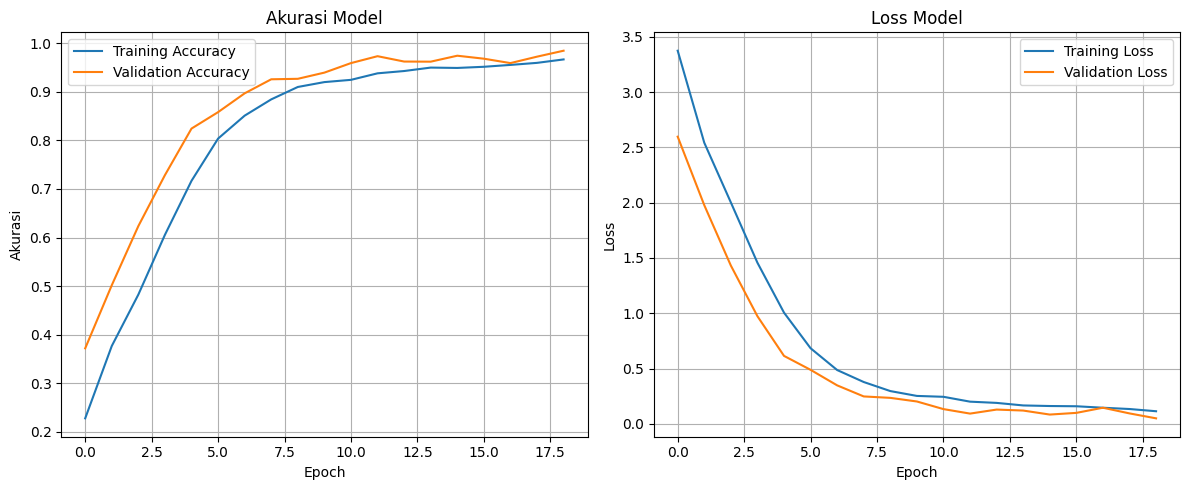

In [36]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Hasil yang ditampilkan menunjukkan grafik akurasi dan loss model selama proses pelatihan. Akurasi model mencapai nilai sempurna (1.0) dan cenderung stabil, dengan akurasi training dan validasi yang hampir identik, mengindikasikan model yang sangat baik dalam mempelajari data tanpa overfitting. Grafik loss menurun secara signifikan dari nilai awal sekitar 3.5 hingga mendekati 0, menunjukkan konvergensi yang sukses selama pelatihan.

#save model

In [37]:
import keras
import tensorflow as tf

model.save("model.h5")


#**TFJS**

In [38]:

!pip install tensorflowjs

import tensorflowjs as tfjs

!mkdir -p tfjs_model

tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


#**TFLITE**

In [39]:
model.export('saved_model')
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

# Simpan model.tflite
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Get the class names from the train dataset
labels = train_dir.class_names

with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 117), dtype=tf.float32, name=None)
Captures:
  136511201832272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511201831696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511201829968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511201831504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511201830544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511041397648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511041401104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511041400144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511041397840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511041397456: TensorSpec(shape=(), dtype=tf.resource, name=None)


#**Inference**



Prediksi Output (probabilitas): [[2.13502836e-03 3.72379794e-09 1.81061376e-04 1.63367432e-07
  2.10199165e-08 7.07313211e-06 2.05606099e-07 4.10334578e-05
  5.62657043e-02 3.76801472e-06 3.41667561e-04 6.18215490e-05
  6.73756469e-04 3.92335816e-04 5.85873146e-03 8.50296128e-05
  1.86039233e-06 9.17065179e-09 1.95909138e-07 4.42176670e-01
  4.82116884e-04 1.96783236e-04 9.65691971e-09 9.45962142e-07
  4.73754147e-09 2.80868649e-01 2.44967028e-04 1.36082594e-08
  9.23678090e-05 6.98816791e-08 9.24747146e-05 1.35994895e-08
  7.52932101e-05 5.43627539e-04 1.19855004e-05 1.13460419e-05
  1.82231868e-10 5.34340252e-05 7.30662025e-04 1.08013473e-05
  7.27939361e-04 6.96390543e-06 5.71168421e-05 4.19195112e-06
  2.28639998e-04 3.15169716e-04 1.86489260e-07 6.05710341e-07
  2.46350446e-05 1.50486138e-02 3.38499085e-03 1.07439273e-05
  1.18977099e-03 3.49604554e-04 5.77570790e-06 9.23223561e-05
  7.85304564e-06 3.35605517e-02 1.20984588e-03 8.78379922e-07
  5.36347216e-05 7.50891882e-09 2.7831

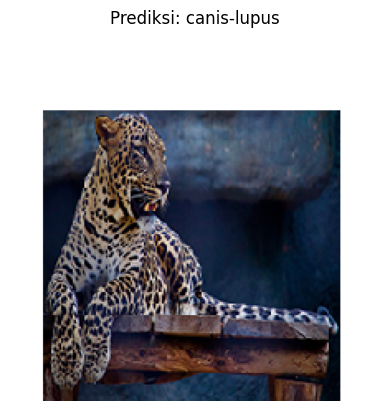

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 1. Muat model TFLite
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")

# 2. Alokasikan memori untuk input/output tensor
interpreter.allocate_tensors()

# 3. Ambil informasi input/output tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 4. Fungsi untuk memuat dan memproses gambar
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224,3))  # Fix target_size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# 5. Siapkan gambar untuk inferensi
img_path = 'split_dataset/test/acinonyx-jubatus/1.png'
input_data = prepare_image(img_path)

# 6. Menyiapkan input untuk interpreter TFLite
input_index = input_details[0]['index']
interpreter.set_tensor(input_index, input_data)

# 7. Jalankan inferensi
interpreter.invoke()

# 8. Ambil hasil output
output_index = output_details[0]['index']
output_data = interpreter.get_tensor(output_index)

# 9. Ambil prediksi kelas
predicted_class = np.argmax(output_data)

# Load the class names from the label file created during TFLite conversion
with open("tflite/label.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

# (Opsional) Daftar nama kelas
#class_names = ['class0', 'class1', 'class2', 'acinonyx-jubatus', 'class4']  # Ganti dengan daftar kelasmu
predicted_label = class_names[predicted_class]

# 10. Tampilkan hasil prediksi
print("Prediksi Output (probabilitas):", output_data)
print("Prediksi Label:", predicted_label)

# 11. Tampilkan gambar
img_display = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img_display)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()

dari hasil prediksi gambar sesuai